# Notebook 1: EDA & Feature Engineering
## Elite Twitch Creator Analytics — Top 1,000 Streamers

**Business Context:** Gaming is a \$200B+ industry. Among the top 1% of Twitch creators (100K+ followers), platforms like YouTube Gaming, TikTok, and Meta Gaming compete to identify and retain mega-streamers (1M+). Partnership investments at this level exceed \$100K+ annually.

**Objective:** Explore the elite creator landscape, engineer quality metrics, and prepare features for downstream ML tasks:
- Mega-streamer prediction (Notebook 2)
- Viewership forecasting (Notebook 3)
- Creator persona clustering (Notebook 4)
- Retention analysis (Notebook 5)

**Key Questions:**
1. How is performance distributed even among the elite?
2. What separates mega-streamers (1M+) from the rest?
3. Which engagement and growth metrics best predict scale?
4. Do content strategies (language, maturity) correlate with success?

## Cell 1 — Imports & Configuration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

# Gaming aesthetic — Twitch purple + cyan
COLORS = ['#9146FF', '#772CE8', '#5C16C5', '#00F0FF', '#00D1F7']
TIER_COLORS = {'Elite': '#9146FF', 'Large': '#772CE8', 'Mega': '#00F0FF', 'Ultra': '#00D1F7'}
sns.set_palette(COLORS)
sns.set_style('whitegrid')
plt.rcParams.update({
    'figure.figsize': (14, 6),
    'figure.dpi': 100,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'font.size': 11,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
})

import os
os.makedirs('../outputs/figures', exist_ok=True)
os.makedirs('../outputs/reports', exist_ok=True)

np.random.seed(42)
print('✓ Environment ready — Elite Creator Analytics')

✓ Environment ready — Elite Creator Analytics


## Cell 2 — Load & Inspect Data

The dataset contains the **top 1,000 Twitch streamers** ranked by watch time. These are pre-filtered elite creators — the top ~0.01% of all Twitch accounts.

In [2]:
# Load data
df = pd.read_csv('../data/twitchdata-update.csv')

# Standardize column names to snake_case
df.columns = (
    df.columns
    .str.strip()
    .str.lower()
    .str.replace(r'[\(\)]', '', regex=True)
    .str.replace(' ', '_')
)

# Rename for clarity
df = df.rename(columns={
    'watch_timeminutes': 'watch_time_minutes',
    'stream_timeminutes': 'stream_time_minutes',
})

# Ensure boolean types
df['partnered'] = df['partnered'].astype(bool)
df['mature'] = df['mature'].astype(bool)

print(f'Shape: {df.shape[0]:,} creators × {df.shape[1]} features')
print(f'\nColumn types:')
print(df.dtypes.to_string())
print(f'\n--- Missing Values ---')
missing = df.isnull().sum()
print(missing[missing > 0].to_string() if missing.sum() > 0 else 'None — dataset is complete')
print(f'\n--- Duplicates ---')
n_dup = df.duplicated(subset='channel').sum()
print(f'{n_dup} duplicate channels' if n_dup else 'No duplicate channels')
print(f'\n--- Numeric Summary ---')
df.describe().T.style.format('{:,.1f}')

Shape: 1,000 creators × 11 features

Column types:
channel                object
watch_time_minutes      int64
stream_time_minutes     int64
peak_viewers            int64
average_viewers         int64
followers               int64
followers_gained        int64
views_gained            int64
partnered                bool
mature                   bool
language               object

--- Missing Values ---
None — dataset is complete

--- Duplicates ---
No duplicate channels

--- Numeric Summary ---


,count,mean,std,min,25%,50%,75%,max
watch_time_minutes,"1,000.0","418,427,930.1","549,635,514.1","122,192,850.0","163,189,893.8","234,990,787.5","433,739,917.5","6,196,161,750.0"
stream_time_minutes,"1,000.0","120,515.2","85,376.2","3,465.0","73,758.8","108,240.0","141,843.8","521,445.0"
peak_viewers,"1,000.0","37,065.1","60,314.3",496.0,"9,113.8","16,676.0","37,569.8","639,375.0"
average_viewers,"1,000.0","4,781.0","8,453.7",235.0,"1,457.8","2,425.0","4,786.2","147,643.0"
followers,"1,000.0","570,054.1","804,413.4","3,660.0","170,546.2","318,063.0","624,332.2","8,938,903.0"
followers_gained,"1,000.0","205,518.5","339,913.7","-15,772.0","43,758.2","98,352.0","236,130.8","3,966,525.0"
views_gained,"1,000.0","11,668,165.6","24,905,722.4","175,788.0","3,880,602.5","6,456,323.5","12,196,762.0","670,137,548.0"


In [3]:
# Preview top creators (sorted by watch time — the dataset's ranking)
df.head(10)

,channel,watch_time_minutes,stream_time_minutes,peak_viewers,average_viewers,followers,followers_gained,views_gained,partnered,mature,language
0,xQcOW,6196161750,215250,222720,27716,3246298,1734810,93036735,True,False,English
1,summit1g,6091677300,211845,310998,25610,5310163,1370184,89705964,True,False,English
2,Gaules,5644590915,515280,387315,10976,1767635,1023779,102611607,True,True,Portuguese
3,ESL_CSGO,3970318140,517740,300575,7714,3944850,703986,106546942,True,False,English
4,Tfue,3671000070,123660,285644,29602,8938903,2068424,78998587,True,False,English
5,Asmongold,3668799075,82260,263720,42414,1563438,554201,61715781,True,False,English
6,NICKMERCS,3360675195,136275,115633,24181,4074287,1089824,46084211,True,False,English
7,Fextralife,3301867485,147885,68795,18985,508816,425468,670137548,True,False,English
8,loltyler1,2928356940,122490,89387,22381,3530767,951730,51349926,True,False,English
9,Anomaly,2865429915,92880,125408,12377,2607076,1532689,36350662,True,False,English


## Cell 3 — Elite Dataset Characterization

**Critical context:** This is NOT a general-population sample. These are the top 1,000 Twitch creators by watch time — roughly the **top 0.01%** of all Twitch accounts (9M+ creators). Even the "smallest" creators here vastly outperform typical streamers.

We define four tiers based on follower count to segment performance within this elite group.

In [4]:
# Follower distribution
print('=== Follower Distribution (Elite Population) ===')
percentiles = [0, 10, 25, 50, 75, 90, 95, 99, 100]
for p in percentiles:
    val = np.percentile(df['followers'], p)
    print(f'  P{p:>3d}: {val:>12,.0f} followers')

# Define tier system
def assign_tier(followers):
    if followers >= 3_000_000:
        return 'Ultra'
    elif followers >= 1_000_000:
        return 'Mega'
    elif followers >= 500_000:
        return 'Large'
    else:
        return 'Elite'

df['tier'] = df['followers'].apply(assign_tier)
df['tier'] = pd.Categorical(df['tier'], categories=['Elite', 'Large', 'Mega', 'Ultra'], ordered=True)

tier_counts = df['tier'].value_counts().sort_index()
print(f'\n=== Tier Distribution ===')
for tier, count in tier_counts.items():
    pct = count / len(df) * 100
    print(f'  {tier:>6s}: {count:>4d} creators ({pct:5.1f}%)')

print(f'\nThis dataset contains the top ~0.01% of all Twitch streamers.')
print(f'Median follower count: {df["followers"].median():,.0f}')
print(f'Even the "Elite" tier here represents extraordinary success on the platform.')

=== Follower Distribution (Elite Population) ===
  P  0:        3,660 followers
  P 10:       96,656 followers
  P 25:      170,546 followers
  P 50:      318,063 followers
  P 75:      624,332 followers
  P 90:    1,251,467 followers
  P 95:    1,792,825 followers
  P 99:    4,118,439 followers
  P100:    8,938,903 followers

=== Tier Distribution ===
   Elite:  663 creators ( 66.3%)
   Large:  204 creators ( 20.4%)
    Mega:  111 creators ( 11.1%)
   Ultra:   22 creators (  2.2%)

This dataset contains the top ~0.01% of all Twitch streamers.
Median follower count: 318,063
Even the "Elite" tier here represents extraordinary success on the platform.


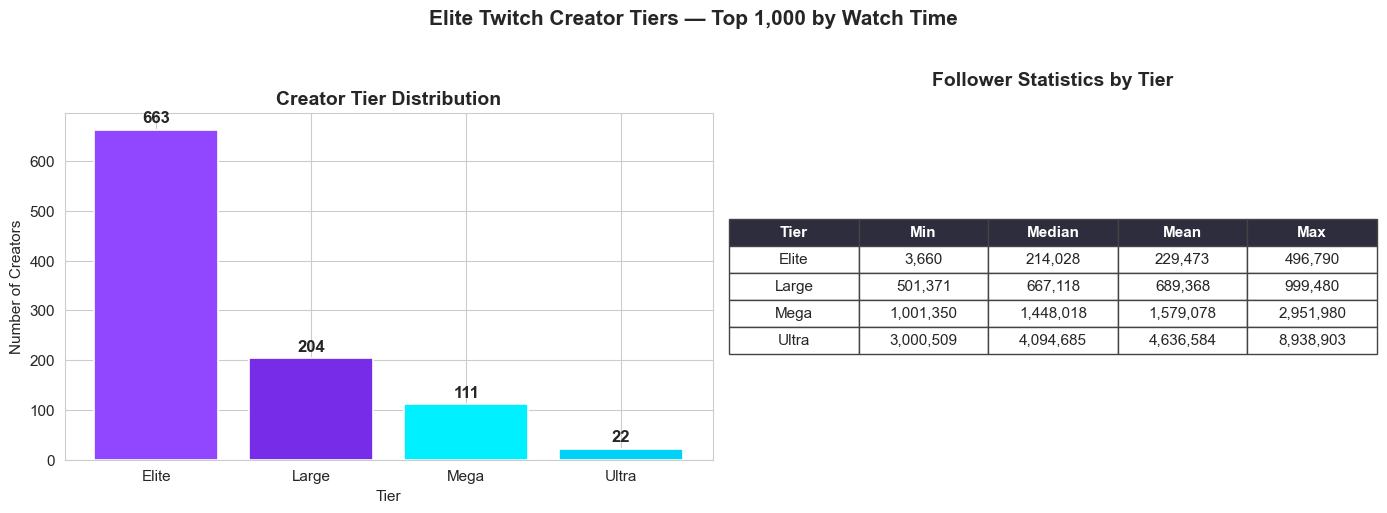

Saved → outputs/figures/01_elite_tiers.png


In [5]:
# Tier distribution bar chart
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart — tier counts
tier_order = ['Elite', 'Large', 'Mega', 'Ultra']
colors = [TIER_COLORS[t] for t in tier_order]
counts = [tier_counts.get(t, 0) for t in tier_order]

bars = axes[0].bar(tier_order, counts, color=colors, edgecolor='white', linewidth=1.2)
for bar, c in zip(bars, counts):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 8,
                 f'{c}', ha='center', va='bottom', fontweight='bold', fontsize=12)
axes[0].set_title('Creator Tier Distribution', fontweight='bold')
axes[0].set_ylabel('Number of Creators')
axes[0].set_xlabel('Tier')

# Summary stats by tier
tier_stats = df.groupby('tier', observed=False)['followers'].agg(['mean', 'median', 'min', 'max'])
tier_stats.columns = ['Mean', 'Median', 'Min', 'Max']

axes[1].axis('off')
table_data = []
for tier in tier_order:
    if tier in tier_stats.index:
        row = tier_stats.loc[tier]
        table_data.append([tier, f'{row["Min"]:,.0f}', f'{row["Median"]:,.0f}',
                           f'{row["Mean"]:,.0f}', f'{row["Max"]:,.0f}'])

table = axes[1].table(
    cellText=table_data,
    colLabels=['Tier', 'Min', 'Median', 'Mean', 'Max'],
    cellLoc='center', loc='center',
    colColours=['#2d2d3d']*5
)
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 1.8)
for key, cell in table.get_celld().items():
    if key[0] == 0:
        cell.set_text_props(color='white', fontweight='bold')
    cell.set_edgecolor('#444')
axes[1].set_title('Follower Statistics by Tier', fontweight='bold', pad=20)

plt.suptitle('Elite Twitch Creator Tiers — Top 1,000 by Watch Time', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../outputs/figures/01_elite_tiers.png')
plt.show()
print('Saved → outputs/figures/01_elite_tiers.png')

## Cell 4 — Feature Engineering: Quality Metrics

Raw counts (followers, viewers) tell us **scale**. Engineered ratios tell us **quality** — which is far more useful for predicting breakout potential.

| Feature | Formula | Business Meaning |
|---|---|---|
| `engagement_rate` | avg_viewers / followers | Audience activation — what share of followers actually watch? |
| `viewer_retention` | avg_viewers / peak_viewers | Attention holding — how many stay past the peak moment? |
| `growth_rate` | followers_gained / stream_time_minutes | Growth efficiency — followers earned per minute streamed |
| `watch_efficiency` | watch_time_minutes / stream_time_minutes | Concurrent audience proxy — total eyeball-minutes per stream-minute |
| `views_per_follower` | views_gained / followers | Content virality — how discoverable beyond existing audience? |
| `quality_score` | Composite of above (MinMax scaled) | Overall creator quality index |

In [6]:
# --- Engagement Quality ---
df['engagement_rate'] = df['average_viewers'] / df['followers'].replace(0, np.nan)

# --- Viewer Retention ---
df['viewer_retention'] = df['average_viewers'] / df['peak_viewers'].replace(0, np.nan)

# --- Growth Velocity ---
df['growth_rate'] = df['followers_gained'] / df['stream_time_minutes'].replace(0, 1)

# --- Watch Efficiency (audience size proxy) ---
df['watch_efficiency'] = df['watch_time_minutes'] / df['stream_time_minutes'].replace(0, 1)

# --- Content Virality ---
df['views_per_follower'] = df['views_gained'] / df['followers'].replace(0, np.nan)

# --- Composite Quality Score ---
quality_features = ['engagement_rate', 'viewer_retention', 'growth_rate']
temp = df[quality_features].fillna(0).copy()
scaler = MinMaxScaler()
scaled = scaler.fit_transform(temp)
df['quality_score'] = scaled.mean(axis=1)

# --- Classification Targets ---
df['is_mega'] = (df['followers'] >= 1_000_000).astype(int)
threshold_top25 = df['followers'].quantile(0.75)
df['is_top_quartile'] = (df['followers'] >= threshold_top25).astype(int)

# Summary
print('=== Engineered Features Summary ===')
eng_features = ['engagement_rate', 'viewer_retention', 'growth_rate',
                'watch_efficiency', 'views_per_follower', 'quality_score']
summary = df[eng_features].describe().T[['mean', '50%', 'std', 'min', 'max']]
summary.columns = ['Mean', 'Median', 'Std', 'Min', 'Max']
print(summary.to_string(float_format=lambda x: f'{x:.4f}'))

print(f'\n=== Target Variable ===')
n_mega = df['is_mega'].sum()
print(f'Mega-streamers (1M+ followers): {n_mega} / {len(df)} ({n_mega/len(df)*100:.1f}%)')
print(f'Top-quartile threshold: {threshold_top25:,.0f} followers')

print(f'\n=== Correlations with Follower Count ===')
corrs = df[eng_features].corrwith(df['followers']).sort_values(ascending=False)
for feat, r in corrs.items():
    print(f'  {feat:<22s}: r = {r:+.3f}')

print(f'\n=== Business Interpretation ===')
print(f'• Median engagement rate: {df["engagement_rate"].median():.3f} — '
      f'only {df["engagement_rate"].median()*100:.1f}% of followers watch on average')
print(f'• Median viewer retention: {df["viewer_retention"].median():.3f} — '
      f'{df["viewer_retention"].median()*100:.1f}% of peak viewers stay as regulars')
print(f'• Median growth rate: {df["growth_rate"].median():.2f} followers/minute streamed')

=== Engineered Features Summary ===
                        Mean    Median       Std      Min         Max
engagement_rate       0.0127    0.0083    0.0262   0.0004      0.6378
viewer_retention      0.1766    0.1605    0.1008   0.0063      0.6347
growth_rate           3.5727    0.9541    9.9901  -0.0837    196.2162
watch_efficiency   5122.9085 2580.3279 9135.2801 236.4151 161136.5962
views_per_follower   46.2205   20.2755  173.1940   1.0612   3002.3300
quality_score         0.1030    0.0930    0.0602   0.0045      0.5424

=== Target Variable ===
Mega-streamers (1M+ followers): 133 / 1000 (13.3%)
Top-quartile threshold: 624,332 followers

=== Correlations with Follower Count ===
  growth_rate           : r = +0.433
  watch_efficiency      : r = +0.430
  quality_score         : r = +0.025
  viewer_retention      : r = -0.079
  views_per_follower    : r = -0.105
  engagement_rate       : r = -0.118

=== Business Interpretation ===
• Median engagement rate: 0.008 — only 0.8% of followers wa

## Cell 5 — Power Law Analysis: Concentration Among the Elite

Even among the top 1,000, we expect a **power law distribution** — a small fraction of creators command a disproportionate share of attention. This is the fundamental dynamic platforms must navigate when allocating partnership budgets.

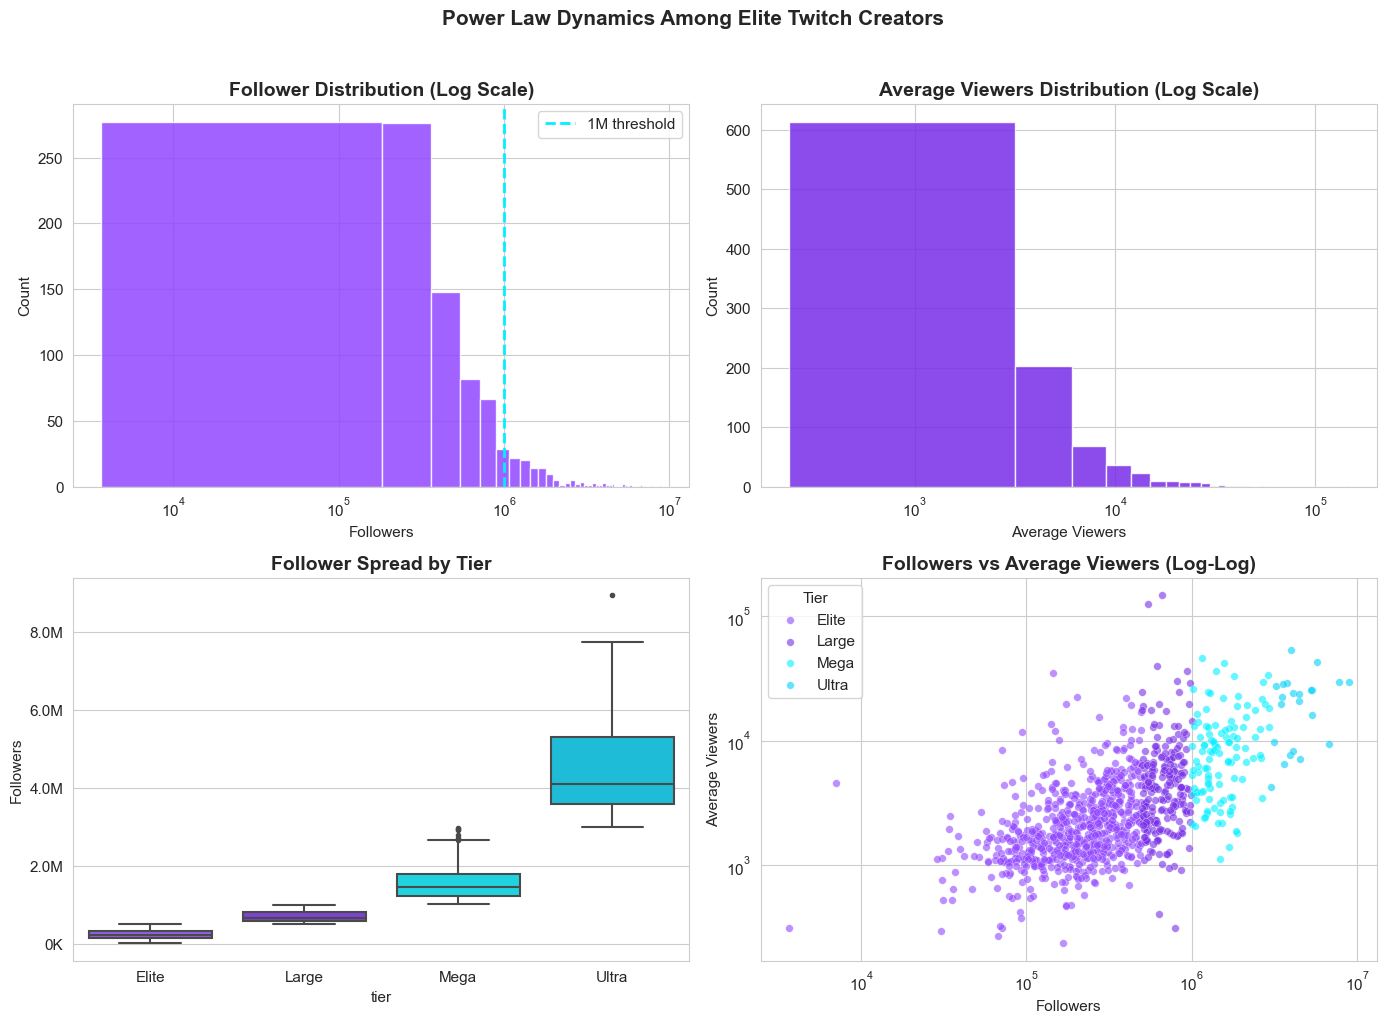

Power Law Concentration:
  • Top 10% of these elite creators hold 42.2% of total followers
  • Gini coefficient (followers): 0.540 (0=equal, 1=total concentration)
  • Interpretation: High inequality — even among the top 1,000, a small group dominates

Saved → outputs/figures/02_power_law_elite.png


In [7]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Follower histogram (log scale)
axes[0, 0].hist(df['followers'], bins=50, color='#9146FF', edgecolor='white', alpha=0.85)
axes[0, 0].set_xscale('log')
axes[0, 0].set_title('Follower Distribution (Log Scale)', fontweight='bold')
axes[0, 0].set_xlabel('Followers')
axes[0, 0].set_ylabel('Count')
axes[0, 0].axvline(1_000_000, color='#00F0FF', linestyle='--', linewidth=2, label='1M threshold')
axes[0, 0].legend()

# 2. Average viewers histogram (log scale)
axes[0, 1].hist(df['average_viewers'], bins=50, color='#772CE8', edgecolor='white', alpha=0.85)
axes[0, 1].set_xscale('log')
axes[0, 1].set_title('Average Viewers Distribution (Log Scale)', fontweight='bold')
axes[0, 1].set_xlabel('Average Viewers')
axes[0, 1].set_ylabel('Count')

# 3. Box plot: followers by tier
tier_palette = {t: TIER_COLORS[t] for t in ['Elite', 'Large', 'Mega', 'Ultra']}
sns.boxplot(data=df, x='tier', y='followers', palette=tier_palette,
            order=['Elite', 'Large', 'Mega', 'Ultra'], ax=axes[1, 0],
            flierprops={'marker': 'o', 'markersize': 3})
axes[1, 0].set_title('Follower Spread by Tier', fontweight='bold')
axes[1, 0].set_ylabel('Followers')
axes[1, 0].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x/1e6:.1f}M' if x >= 1e6 else f'{x/1e3:.0f}K'))

# 4. Log-log scatter: followers vs average viewers
for tier in ['Elite', 'Large', 'Mega', 'Ultra']:
    subset = df[df['tier'] == tier]
    axes[1, 1].scatter(subset['followers'], subset['average_viewers'],
                       c=TIER_COLORS[tier], label=tier, alpha=0.6, s=30, edgecolors='white', linewidth=0.3)
axes[1, 1].set_xscale('log')
axes[1, 1].set_yscale('log')
axes[1, 1].set_title('Followers vs Average Viewers (Log-Log)', fontweight='bold')
axes[1, 1].set_xlabel('Followers')
axes[1, 1].set_ylabel('Average Viewers')
axes[1, 1].legend(title='Tier')

# Power law annotation
sorted_followers = np.sort(df['followers'].values)[::-1]
top10_share = sorted_followers[:100].sum() / sorted_followers.sum() * 100

plt.suptitle('Power Law Dynamics Among Elite Twitch Creators', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../outputs/figures/02_power_law_elite.png')
plt.show()

# Gini coefficient
def gini(array):
    array = np.sort(np.array(array, dtype=float))
    n = len(array)
    index = np.arange(1, n + 1)
    return (2 * np.sum(index * array) - (n + 1) * np.sum(array)) / (n * np.sum(array))

g = gini(df['followers'])
print(f'Power Law Concentration:')
print(f'  • Top 10% of these elite creators hold {top10_share:.1f}% of total followers')
print(f'  • Gini coefficient (followers): {g:.3f} (0=equal, 1=total concentration)')
print(f'  • Interpretation: {"High" if g > 0.5 else "Moderate"} inequality — '
      f'even among the top 1,000, a small group dominates')
print(f'\nSaved → outputs/figures/02_power_law_elite.png')

## Cell 6 — Mega vs Elite-Only: What Separates the Best from the Great?

The most actionable question for platforms: among creators who are already successful (100K+ followers), **what distinguishes those who break through to 1M+?** This analysis directly informs talent acquisition strategy.

In [8]:
# Statistical comparison
mega = df[df['is_mega'] == 1]
elite_only = df[df['is_mega'] == 0]

compare_cols = ['stream_time_minutes', 'average_viewers', 'peak_viewers',
                'engagement_rate', 'viewer_retention', 'growth_rate',
                'watch_efficiency', 'views_per_follower', 'quality_score']

results = []
for col in compare_cols:
    m_vals = mega[col].dropna()
    e_vals = elite_only[col].dropna()
    t_stat, p_val = stats.ttest_ind(m_vals, e_vals, equal_var=False)
    # Cohen's d
    pooled_std = np.sqrt((m_vals.std()**2 + e_vals.std()**2) / 2)
    d = (m_vals.mean() - e_vals.mean()) / pooled_std if pooled_std > 0 else 0
    pct_diff = (m_vals.mean() - e_vals.mean()) / e_vals.mean() * 100 if e_vals.mean() != 0 else 0
    results.append({
        'Feature': col,
        'Mega Mean': m_vals.mean(),
        'Elite-Only Mean': e_vals.mean(),
        'Diff %': pct_diff,
        't-stat': t_stat,
        'p-value': p_val,
        'Cohen d': d,
        'Significant': '***' if p_val < 0.001 else ('**' if p_val < 0.01 else ('*' if p_val < 0.05 else 'ns'))
    })

comparison_df = pd.DataFrame(results)
print('=== Mega-Streamers (1M+) vs Elite-Only (<1M) ===')
print(f'Mega: {len(mega)} creators | Elite-Only: {len(elite_only)} creators\n')
print(comparison_df.to_string(index=False, float_format=lambda x: f'{x:.3f}'))
print(f'\nSignificance: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant')

=== Mega-Streamers (1M+) vs Elite-Only (<1M) ===
Mega: 133 creators | Elite-Only: 867 creators

            Feature  Mega Mean  Elite-Only Mean  Diff %  t-stat  p-value  Cohen d Significant
stream_time_minutes 102025.827       123351.471 -17.289  -2.865    0.005   -0.258          **
    average_viewers  12037.135         3667.937 228.172   9.040    0.000    0.929         ***
       peak_viewers  98966.872        27569.155 258.977   7.680    0.000    0.885         ***
    engagement_rate      0.006            0.014 -53.691  -6.911    0.000   -0.366         ***
   viewer_retention      0.158            0.179 -11.864  -2.592    0.010   -0.225           *
        growth_rate     13.136            2.106 523.812   5.488    0.000    0.664         ***
   watch_efficiency  13103.554         3898.657 236.104   9.143    0.000    0.943         ***
 views_per_follower     13.008           51.315 -74.651  -6.031    0.000   -0.292         ***
      quality_score      0.106            0.103   3.496   

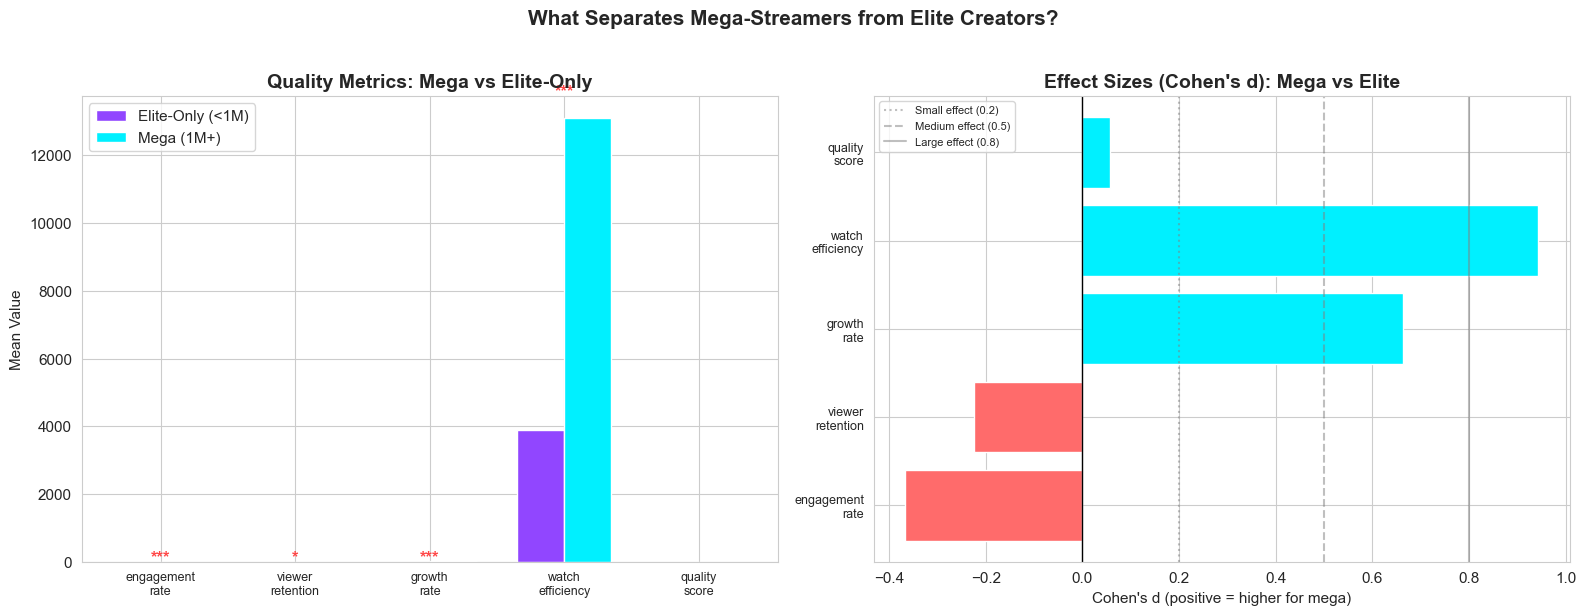

Key Insight: The strongest differentiator is "watch_efficiency"
  Mega-streamers show 236% higher values (p=3.36e-16, d=0.94)

Saved → outputs/figures/03_mega_vs_elite.png


In [9]:
# Visualization: side-by-side bars
# Normalize each metric to show relative difference
plot_cols = ['engagement_rate', 'viewer_retention', 'growth_rate',
             'watch_efficiency', 'quality_score']

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Panel 1: Normalized comparison bars
mega_means = [mega[c].mean() for c in plot_cols]
elite_means = [elite_only[c].mean() for c in plot_cols]

x = np.arange(len(plot_cols))
width = 0.35
bars1 = axes[0].bar(x - width/2, elite_means, width, label='Elite-Only (<1M)',
                     color='#9146FF', edgecolor='white')
bars2 = axes[0].bar(x + width/2, mega_means, width, label='Mega (1M+)',
                     color='#00F0FF', edgecolor='white')

# Add significance stars
sig_map = {c: r['Significant'] for _, r in comparison_df.iterrows() for c in [r['Feature']]}
for i, col in enumerate(plot_cols):
    sig = sig_map.get(col, '')
    if sig != 'ns':
        max_val = max(mega_means[i], elite_means[i])
        axes[0].text(i, max_val * 1.05, sig, ha='center', fontsize=12, fontweight='bold', color='#FF4444')

axes[0].set_xticks(x)
axes[0].set_xticklabels([c.replace('_', '\n') for c in plot_cols], fontsize=9)
axes[0].set_title('Quality Metrics: Mega vs Elite-Only', fontweight='bold')
axes[0].legend()
axes[0].set_ylabel('Mean Value')

# Panel 2: Effect sizes
effect_data = comparison_df.set_index('Feature').loc[plot_cols, 'Cohen d'].values
bar_colors = ['#00F0FF' if d > 0 else '#FF6B6B' for d in effect_data]
axes[1].barh(plot_cols, effect_data, color=bar_colors, edgecolor='white')
axes[1].axvline(0.2, color='gray', linestyle=':', alpha=0.5, label='Small effect (0.2)')
axes[1].axvline(0.5, color='gray', linestyle='--', alpha=0.5, label='Medium effect (0.5)')
axes[1].axvline(0.8, color='gray', linestyle='-', alpha=0.5, label='Large effect (0.8)')
axes[1].axvline(0, color='black', linewidth=1)
axes[1].set_title("Effect Sizes (Cohen's d): Mega vs Elite", fontweight='bold')
axes[1].set_xlabel("Cohen's d (positive = higher for mega)")
axes[1].legend(fontsize=8)
axes[1].set_yticklabels([c.replace('_', '\n') for c in plot_cols], fontsize=9)

plt.suptitle('What Separates Mega-Streamers from Elite Creators?',
             fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../outputs/figures/03_mega_vs_elite.png')
plt.show()

# Key insight
top_diff = comparison_df.loc[comparison_df['Cohen d'].abs().idxmax()]
print(f'Key Insight: The strongest differentiator is "{top_diff["Feature"]}"')
print(f'  Mega-streamers show {abs(top_diff["Diff %"]):.0f}% {"higher" if top_diff["Diff %"] > 0 else "lower"} values '
      f'(p={top_diff["p-value"]:.2e}, d={top_diff["Cohen d"]:.2f})')
print(f'\nSaved → outputs/figures/03_mega_vs_elite.png')

## Cell 7 — Engagement Quality Analysis

A fundamental question: **does engagement scale with audience size, or does it erode?** If larger creators have lower engagement rates, it suggests that raw follower counts overstate their active audience — critical for platform valuation of partnerships.

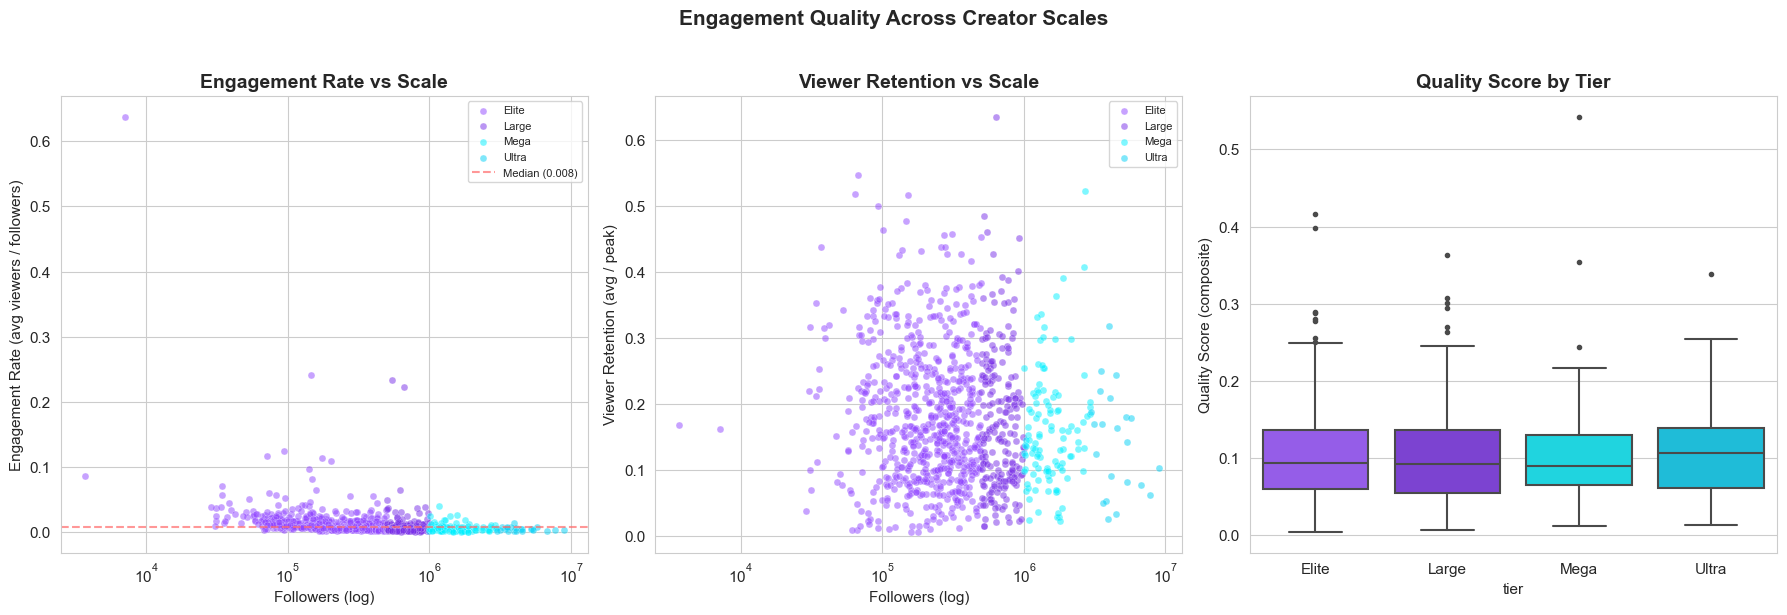

=== Statistical Insights ===
  Engagement rate vs followers: ρ = -0.496 (p = 3.17e-63)
  → Negative relationship: larger creators have lower engagement rates

  Viewer retention vs followers: ρ = -0.088 (p = 5.38e-03)

  Quality score ANOVA across tiers: F = 0.33, p = 8.03e-01
  → Quality score does not differ significantly across tiers

Engagement Paradox: Larger streamers have lower engagement rates
but dramatically higher absolute viewer counts — a key consideration for partnership ROI.

Saved → outputs/figures/04_engagement_quality.png


In [10]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Engagement rate vs followers
for tier in ['Elite', 'Large', 'Mega', 'Ultra']:
    subset = df[df['tier'] == tier]
    axes[0].scatter(subset['followers'], subset['engagement_rate'],
                    c=TIER_COLORS[tier], label=tier, alpha=0.5, s=25, edgecolors='white', linewidth=0.3)
axes[0].axhline(df['engagement_rate'].median(), color='#FF6B6B', linestyle='--',
                alpha=0.7, label=f'Median ({df["engagement_rate"].median():.3f})')
axes[0].set_xscale('log')
axes[0].set_title('Engagement Rate vs Scale', fontweight='bold')
axes[0].set_xlabel('Followers (log)')
axes[0].set_ylabel('Engagement Rate (avg viewers / followers)')
axes[0].legend(fontsize=8)

# 2. Viewer retention vs followers
for tier in ['Elite', 'Large', 'Mega', 'Ultra']:
    subset = df[df['tier'] == tier]
    axes[1].scatter(subset['followers'], subset['viewer_retention'],
                    c=TIER_COLORS[tier], label=tier, alpha=0.5, s=25, edgecolors='white', linewidth=0.3)
axes[1].set_xscale('log')
axes[1].set_title('Viewer Retention vs Scale', fontweight='bold')
axes[1].set_xlabel('Followers (log)')
axes[1].set_ylabel('Viewer Retention (avg / peak)')
axes[1].legend(fontsize=8)

# 3. Quality score by tier
sns.boxplot(data=df, x='tier', y='quality_score', palette=TIER_COLORS,
            order=['Elite', 'Large', 'Mega', 'Ultra'], ax=axes[2],
            flierprops={'marker': 'o', 'markersize': 3})
axes[2].set_title('Quality Score by Tier', fontweight='bold')
axes[2].set_ylabel('Quality Score (composite)')

plt.suptitle('Engagement Quality Across Creator Scales', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../outputs/figures/04_engagement_quality.png')
plt.show()

# Statistical analysis
r_eng, p_eng = stats.spearmanr(df['followers'], df['engagement_rate'].fillna(0))
r_ret, p_ret = stats.spearmanr(df['followers'], df['viewer_retention'].fillna(0))

# ANOVA: quality_score across tiers
tier_groups = [group['quality_score'].dropna().values for _, group in df.groupby('tier', observed=False)]
f_stat, p_anova = stats.f_oneway(*tier_groups)

print('=== Statistical Insights ===')
print(f'  Engagement rate vs followers: ρ = {r_eng:.3f} (p = {p_eng:.2e})')
print(f'  → {"Negative" if r_eng < 0 else "Positive"} relationship: '
      f'{"larger creators have lower engagement rates" if r_eng < 0 else "larger creators maintain engagement"}')
print(f'\n  Viewer retention vs followers: ρ = {r_ret:.3f} (p = {p_ret:.2e})')
print(f'\n  Quality score ANOVA across tiers: F = {f_stat:.2f}, p = {p_anova:.2e}')
print(f'  → Quality score {"differs" if p_anova < 0.05 else "does not differ"} significantly across tiers')

print(f'\nEngagement Paradox: Larger streamers have {"lower" if r_eng < 0 else "similar"} engagement rates')
print(f'but dramatically higher absolute viewer counts — a key consideration for partnership ROI.')
print(f'\nSaved → outputs/figures/04_engagement_quality.png')

## Cell 8 — Growth Velocity Analysis

**Growth rate** (followers gained per minute streamed) measures how efficiently a creator converts streaming time into audience growth. This is the metric platforms care most about when identifying rising talent — a creator with high growth velocity is worth investing in regardless of current size.

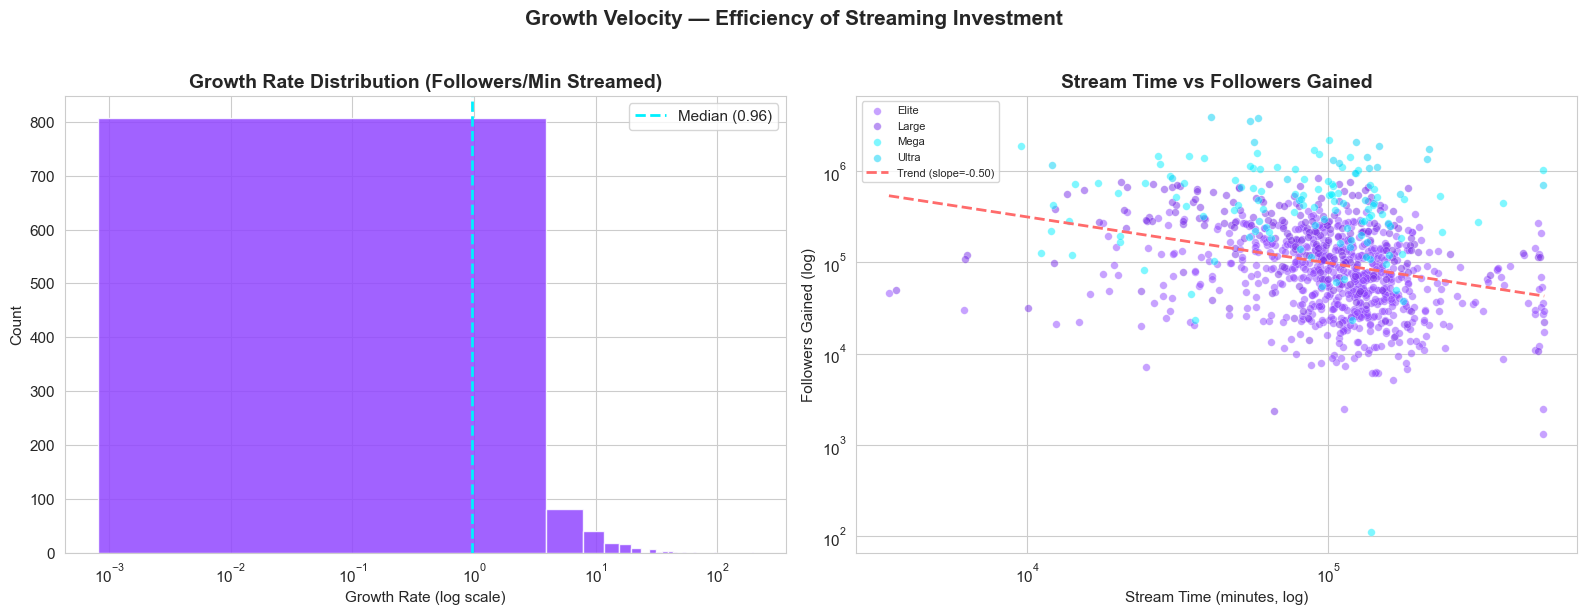

=== Growth Velocity by Tier (Median) ===
  Elite: 0.57 followers/minute
  Large: 2.42 followers/minute
  Mega: 5.13 followers/minute
  Ultra: 10.92 followers/minute

Stream time ↔ followers gained: ρ = -0.322 (p = 1.86e-25)
Log-log slope: -0.50 (if 1.0 = linear; <1.0 = diminishing returns)

Insight: Slope of -0.50 indicates diminishing returns — 
doubling stream time increases followers gained by only ~-30%

=== Top 10 Most Efficient Growers ===
         channel  tier  followers  followers_gained  stream_time_minutes  growth_rate
        SLAKUN10  Mega    1874932           1874846                 9555   196.216222
       auronplay Ultra    3983847           3966525                40575    97.757856
        Fortnite Ultra    3558217           1163448                12030    96.712219
          Rubius Ultra    5751354           3820532                58275    65.560395
        TheGrefg Ultra    3795667           3593081                54855    65.501431
        Mongraal  Mega    2951980 

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Growth rate distribution
growth_data = df['growth_rate'][df['growth_rate'] > 0]
axes[0].hist(growth_data, bins=50, color='#9146FF', edgecolor='white', alpha=0.85)
axes[0].set_xscale('log')
axes[0].axvline(growth_data.median(), color='#00F0FF', linestyle='--', linewidth=2,
                label=f'Median ({growth_data.median():.2f})')
axes[0].set_title('Growth Rate Distribution (Followers/Min Streamed)', fontweight='bold')
axes[0].set_xlabel('Growth Rate (log scale)')
axes[0].set_ylabel('Count')
axes[0].legend()

# 2. Stream time vs followers gained
for tier in ['Elite', 'Large', 'Mega', 'Ultra']:
    subset = df[df['tier'] == tier]
    axes[1].scatter(subset['stream_time_minutes'], subset['followers_gained'],
                    c=TIER_COLORS[tier], label=tier, alpha=0.5, s=30, edgecolors='white', linewidth=0.3)

# Trend line (overall)
mask = (df['stream_time_minutes'] > 0) & (df['followers_gained'] > 0)
log_x = np.log10(df.loc[mask, 'stream_time_minutes'])
log_y = np.log10(df.loc[mask, 'followers_gained'])
slope, intercept, r_val, _, _ = stats.linregress(log_x, log_y)
x_fit = np.linspace(log_x.min(), log_x.max(), 100)
axes[1].plot(10**x_fit, 10**(slope * x_fit + intercept), '--', color='#FF6B6B',
             linewidth=2, label=f'Trend (slope={slope:.2f})')

axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_title('Stream Time vs Followers Gained', fontweight='bold')
axes[1].set_xlabel('Stream Time (minutes, log)')
axes[1].set_ylabel('Followers Gained (log)')
axes[1].legend(fontsize=8)

plt.suptitle('Growth Velocity — Efficiency of Streaming Investment',
             fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../outputs/figures/05_growth_velocity.png')
plt.show()

# Statistical analysis
tier_growth = df.groupby('tier', observed=False)['growth_rate'].median()
print(f'=== Growth Velocity by Tier (Median) ===')
for tier, gr in tier_growth.items():
    print(f'  {tier}: {gr:.2f} followers/minute')

r_time, p_time = stats.spearmanr(df.loc[mask, 'stream_time_minutes'],
                                  df.loc[mask, 'followers_gained'])
print(f'\nStream time ↔ followers gained: ρ = {r_time:.3f} (p = {p_time:.2e})')
print(f'Log-log slope: {slope:.2f} (if 1.0 = linear; <1.0 = diminishing returns)')
print(f'\nInsight: Slope of {slope:.2f} indicates {"diminishing" if slope < 1 else "increasing"} returns — ')
if slope < 1:
    pct_gain = (2**slope - 1) * 100
    print(f'doubling stream time increases followers gained by only ~{pct_gain:.0f}%')

# Efficient growers
high_growth = df.nlargest(10, 'growth_rate')[['channel', 'tier', 'followers', 'followers_gained',
                                                'stream_time_minutes', 'growth_rate']]
print(f'\n=== Top 10 Most Efficient Growers ===')
print(high_growth.to_string(index=False))
print(f'\nSaved → outputs/figures/05_growth_velocity.png')

## Cell 9 — Content Strategy Patterns

Three content-level factors in this dataset: **language**, **mature content flag**, and **partnership status**. These proxy for content strategy choices and market positioning.

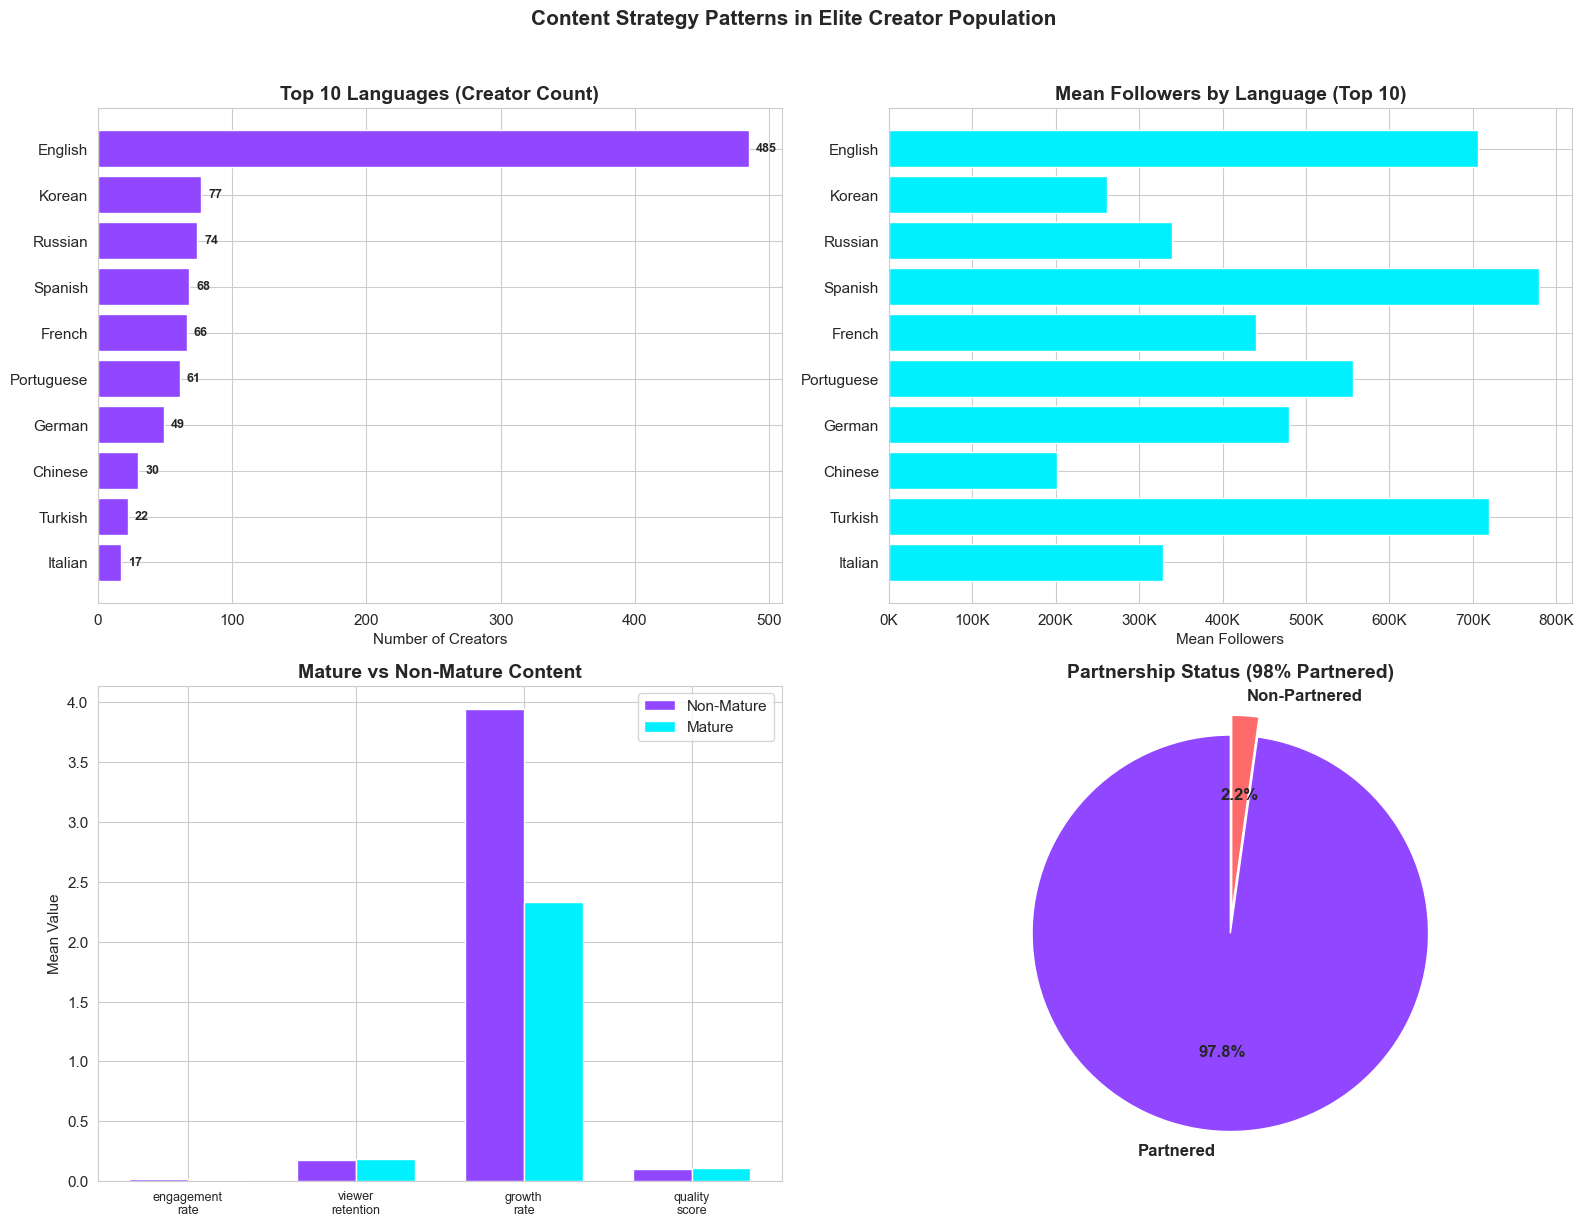

=== Language & Mega-Streamer Status ===
  Chi-square (top 5 languages × mega status): χ² = 25.95, p = 0.0000
  → Mega-streamer status is dependent on language

=== Mature Content Analysis ===
  followers: t = -3.56, p = 0.0004 ***
  engagement_rate: t = -2.99, p = 0.0028 **
  viewer_retention: t = 1.82, p = 0.0701 ns

=== Non-Partnered Creators (22) ===
  Mean followers: 331,943
  Mean engagement rate: 0.0598
  Interesting: These creators reached top-1000 watch time without partnership.

Saved → outputs/figures/06_content_strategy.png


In [12]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Top 10 languages by count
lang_counts = df['language'].value_counts().head(10)
axes[0, 0].barh(lang_counts.index[::-1], lang_counts.values[::-1],
                color='#9146FF', edgecolor='white')
axes[0, 0].set_title('Top 10 Languages (Creator Count)', fontweight='bold')
axes[0, 0].set_xlabel('Number of Creators')
for i, (lang, cnt) in enumerate(zip(lang_counts.index[::-1], lang_counts.values[::-1])):
    axes[0, 0].text(cnt + 5, i, str(cnt), va='center', fontweight='bold', fontsize=9)

# 2. Average followers by language (top 10)
top_langs = lang_counts.index.tolist()
lang_followers = df[df['language'].isin(top_langs)].groupby('language')['followers'].mean()
lang_followers = lang_followers.reindex(top_langs)
axes[0, 1].barh(lang_followers.index[::-1], lang_followers.values[::-1],
                color='#00F0FF', edgecolor='white')
axes[0, 1].set_title('Mean Followers by Language (Top 10)', fontweight='bold')
axes[0, 1].set_xlabel('Mean Followers')
axes[0, 1].xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x/1e6:.1f}M' if x >= 1e6 else f'{x/1e3:.0f}K'))

# 3. Mature vs non-mature comparison
mature_metrics = ['engagement_rate', 'viewer_retention', 'growth_rate', 'quality_score']
mature_means = df.groupby('mature')[mature_metrics].mean()

x = np.arange(len(mature_metrics))
width = 0.35
axes[1, 0].bar(x - width/2, mature_means.loc[False], width, label='Non-Mature',
               color='#9146FF', edgecolor='white')
axes[1, 0].bar(x + width/2, mature_means.loc[True], width, label='Mature',
               color='#00F0FF', edgecolor='white')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels([m.replace('_', '\n') for m in mature_metrics], fontsize=9)
axes[1, 0].set_title('Mature vs Non-Mature Content', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].set_ylabel('Mean Value')

# 4. Partnership analysis
partner_rate = df['partnered'].mean() * 100
non_partnered = df[~df['partnered']]
partner_counts = df['partnered'].value_counts()
axes[1, 1].pie(partner_counts, labels=['Partnered', 'Non-Partnered'],
               colors=['#9146FF', '#FF6B6B'], autopct='%1.1f%%',
               textprops={'fontsize': 12, 'fontweight': 'bold'},
               explode=(0, 0.1), startangle=90)
axes[1, 1].set_title(f'Partnership Status ({partner_rate:.0f}% Partnered)', fontweight='bold')

plt.suptitle('Content Strategy Patterns in Elite Creator Population',
             fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../outputs/figures/06_content_strategy.png')
plt.show()

# Statistical tests
print('=== Language & Mega-Streamer Status ===')
# Chi-square: is mega-streamer status independent of language?
top5_langs = lang_counts.index[:5].tolist()
ct = pd.crosstab(df[df['language'].isin(top5_langs)]['language'], df[df['language'].isin(top5_langs)]['is_mega'])
chi2, p_chi, dof, _ = stats.chi2_contingency(ct)
print(f'  Chi-square (top 5 languages × mega status): χ² = {chi2:.2f}, p = {p_chi:.4f}')
print(f'  → Mega-streamer status is {"dependent on" if p_chi < 0.05 else "independent of"} language')

print(f'\n=== Mature Content Analysis ===')
for metric in ['followers', 'engagement_rate', 'viewer_retention']:
    t, p = stats.ttest_ind(df[df['mature']][metric].dropna(),
                           df[~df['mature']][metric].dropna(), equal_var=False)
    print(f'  {metric}: t = {t:.2f}, p = {p:.4f} {"***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else "ns"}')

print(f'\n=== Non-Partnered Creators ({len(non_partnered)}) ===')
if len(non_partnered) > 0:
    print(f'  Mean followers: {non_partnered["followers"].mean():,.0f}')
    print(f'  Mean engagement rate: {non_partnered["engagement_rate"].mean():.4f}')
    print(f'  Interesting: These creators reached top-1000 watch time without partnership.')

print(f'\nSaved → outputs/figures/06_content_strategy.png')

## Cell 10 — Correlation Matrix: Feature Relationships

Understanding feature correlations serves two purposes: (1) identifying which metrics most predict follower count/mega status, and (2) flagging multicollinearity issues that would affect our ML models.

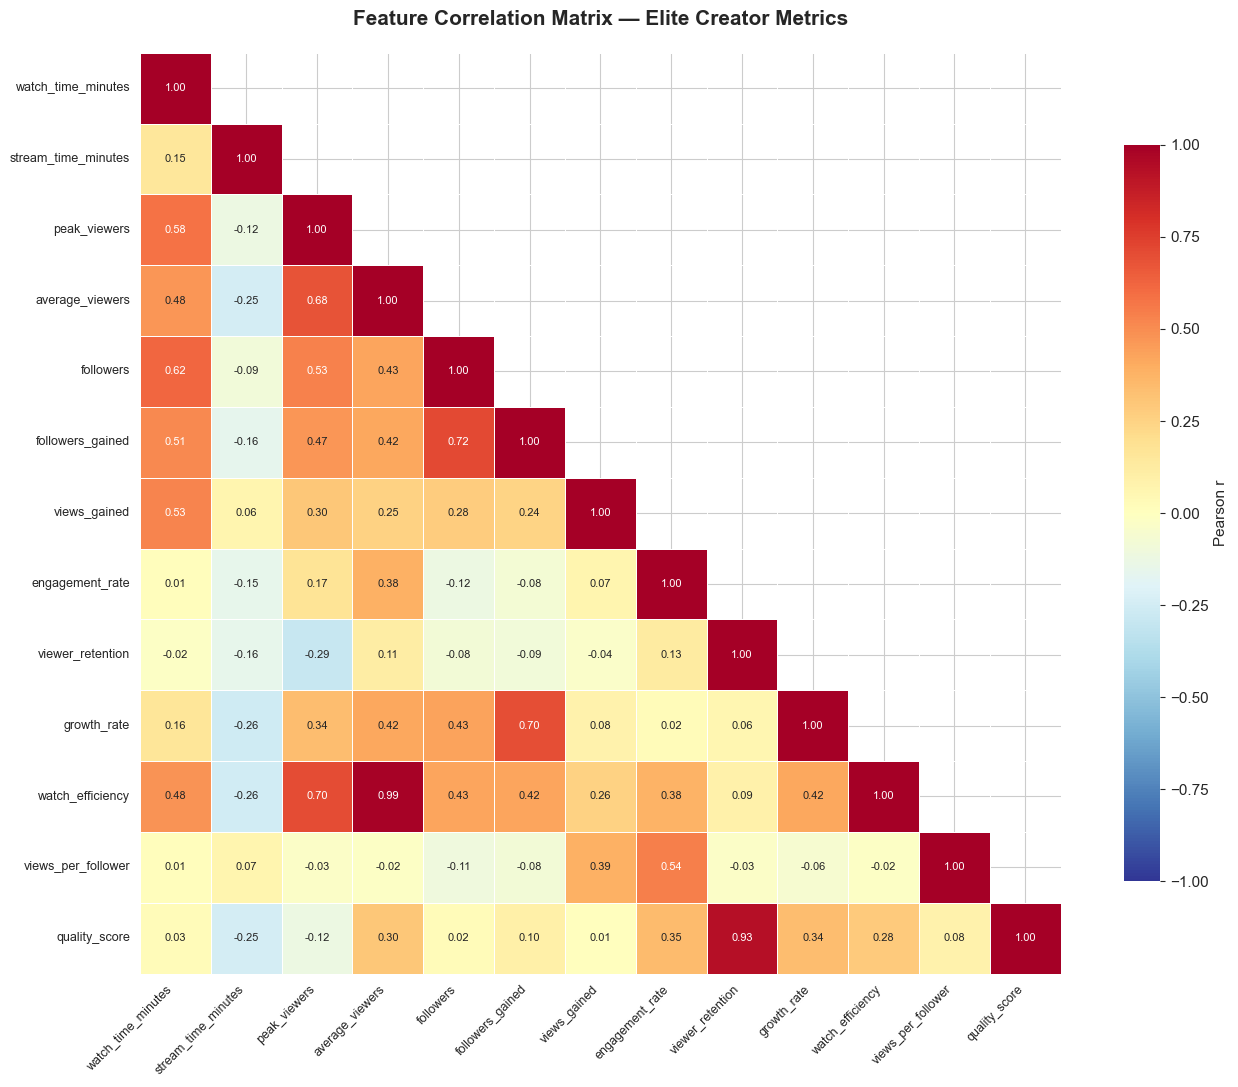

=== Top Correlations with Followers ===
  followers_gained      : r = +0.716 ← STRONG
  watch_time_minutes    : r = +0.620 ← STRONG
  peak_viewers          : r = +0.533 ← STRONG
  growth_rate           : r = +0.433
  watch_efficiency      : r = +0.430
  average_viewers       : r = +0.428
  views_gained          : r = +0.276
  engagement_rate       : r = -0.118
  views_per_follower    : r = -0.105
  stream_time_minutes   : r = -0.091
  viewer_retention      : r = -0.079
  quality_score         : r = +0.025

=== Multicollinearity Warnings (|r| > 0.8) ===
  average_viewers ↔ watch_efficiency: r = 0.992
  viewer_retention ↔ quality_score: r = 0.932

→ Consider dropping one feature from each highly correlated pair in ML models.

Saved → outputs/figures/07_correlation_matrix.png


In [13]:
# Select numeric features for correlation
corr_cols = ['watch_time_minutes', 'stream_time_minutes', 'peak_viewers', 'average_viewers',
             'followers', 'followers_gained', 'views_gained',
             'engagement_rate', 'viewer_retention', 'growth_rate',
             'watch_efficiency', 'views_per_follower', 'quality_score']

corr_matrix = df[corr_cols].corr()

# Heatmap
fig, ax = plt.subplots(figsize=(14, 11))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdYlBu_r',
            center=0, vmin=-1, vmax=1, square=True, linewidths=0.5,
            annot_kws={'size': 8}, ax=ax,
            cbar_kws={'shrink': 0.8, 'label': 'Pearson r'})
ax.set_title('Feature Correlation Matrix — Elite Creator Metrics',
             fontsize=15, fontweight='bold', pad=20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=9)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=9)

plt.tight_layout()
plt.savefig('../outputs/figures/07_correlation_matrix.png')
plt.show()

# Top correlations with followers
print('=== Top Correlations with Followers ===')
follower_corrs = corr_matrix['followers'].drop('followers').sort_values(key=abs, ascending=False)
for feat, r in follower_corrs.items():
    flag = ' ← STRONG' if abs(r) > 0.5 else ''
    print(f'  {feat:<22s}: r = {r:+.3f}{flag}')

# Multicollinearity warnings
print(f'\n=== Multicollinearity Warnings (|r| > 0.8) ===')
high_corr_pairs = []
for i in range(len(corr_cols)):
    for j in range(i+1, len(corr_cols)):
        r = corr_matrix.iloc[i, j]
        if abs(r) > 0.8:
            high_corr_pairs.append((corr_cols[i], corr_cols[j], r))
            print(f'  {corr_cols[i]} ↔ {corr_cols[j]}: r = {r:.3f}')

if not high_corr_pairs:
    print('  No pairs with |r| > 0.8 found')

print(f'\n→ Consider dropping one feature from each highly correlated pair in ML models.')
print(f'\nSaved → outputs/figures/07_correlation_matrix.png')

## Cell 11 — Outlier Analysis: Exceptional Performers

Outliers in this context aren't data quality issues — they're the **most interesting creators**. These are streamers who dramatically outperform their peers in specific dimensions, representing potential case studies for platform strategy.

In [14]:
# Identify top performers in each dimension
categories = {
    'Highest Engagement (Small but Mighty)': 'engagement_rate',
    'Fastest Growth (Explosive)': 'growth_rate',
    'Best Retention (Loyal Audience)': 'viewer_retention',
    'Highest Quality Score (All-Around)': 'quality_score'
}

display_cols = ['channel', 'tier', 'followers', 'average_viewers']

for title, col in categories.items():
    print(f'\n=== {title} ===')
    top5 = df.nlargest(5, col)[display_cols + [col]].copy()
    top5['followers'] = top5['followers'].apply(lambda x: f'{x:,.0f}')
    top5['average_viewers'] = top5['average_viewers'].apply(lambda x: f'{x:,.0f}')
    top5[col] = top5[col].apply(lambda x: f'{x:.4f}')
    print(top5.to_string(index=False))


=== Highest Engagement (Small but Mighty) ===
   channel  tier followers average_viewers engagement_rate
 Sinner666 Elite     7,102           4,530          0.6378
  KEEMSTAR Elite   146,035          35,333          0.2419
dota2ti_ru Large   541,644         126,232          0.2331
   dota2ti Large   663,297         147,643          0.2226
Flashpoint Elite    93,616          11,713          0.1251

=== Fastest Growth (Explosive) ===
  channel  tier followers average_viewers growth_rate
 SLAKUN10  Mega 1,874,932          18,906    196.2162
auronplay Ultra 3,983,847          53,986     97.7579
 Fortnite Ultra 3,558,217          28,584     96.7122
   Rubius Ultra 5,751,354          42,948     65.5604
 TheGrefg Ultra 3,795,667          28,887     65.5014

=== Best Retention (Loyal Audience) ===
   channel  tier followers average_viewers viewer_retention
   Arteezy Large   634,982          19,681           0.6347
Japan_ASMR Elite    67,707             271           0.5464
     Faker  Mega 2

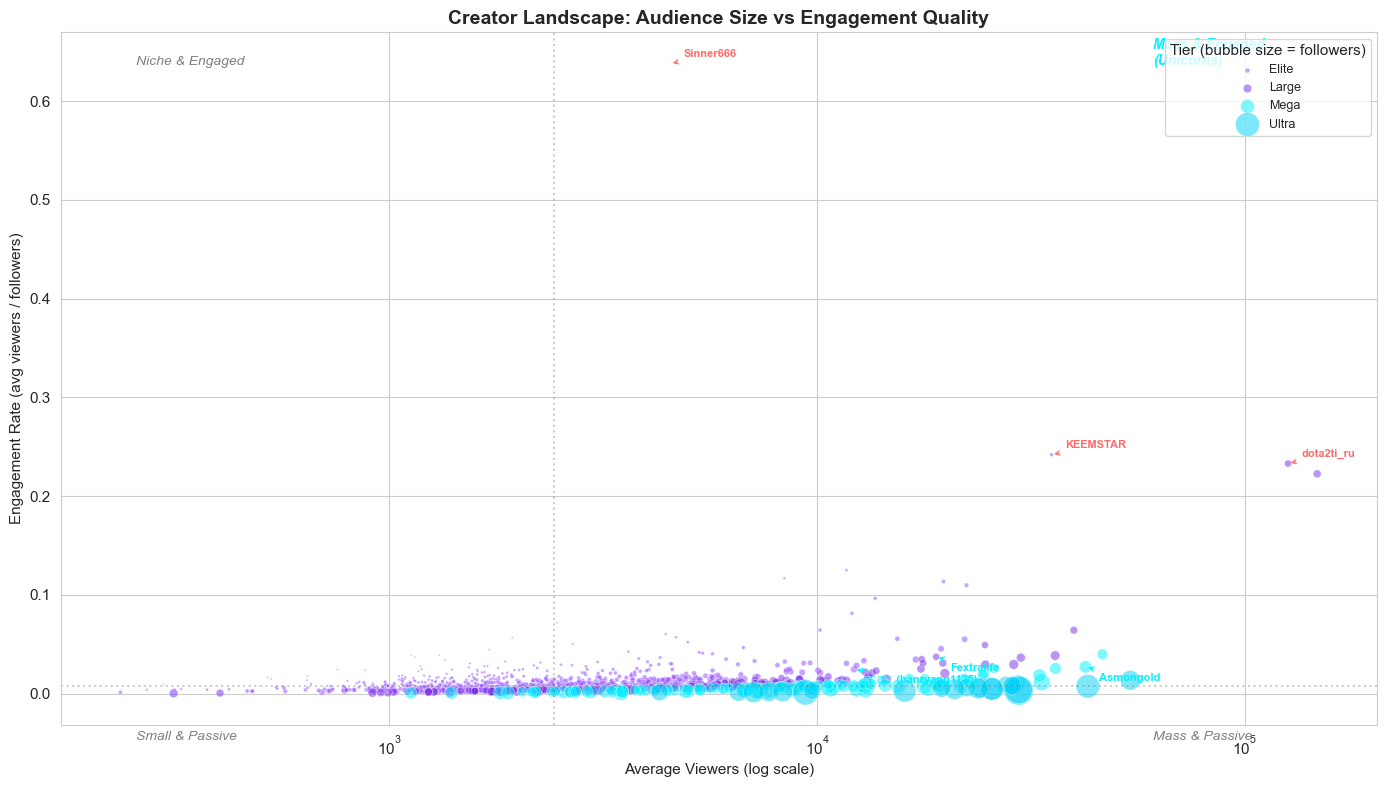

"Unicorn" creators (top 10% viewers AND top 25% engagement): 49
These rare creators combine massive scale with high audience activation — prime partnership targets.

Saved → outputs/figures/08_outliers.png


In [15]:
# Outlier scatter plot
fig, ax = plt.subplots(figsize=(14, 8))

# Main scatter
for tier in ['Elite', 'Large', 'Mega', 'Ultra']:
    subset = df[df['tier'] == tier]
    ax.scatter(subset['average_viewers'], subset['engagement_rate'],
              s=subset['followers'] / 20000, c=TIER_COLORS[tier],
              label=tier, alpha=0.5, edgecolors='white', linewidth=0.5)

# Annotate top outliers
# Top engagement
top_eng = df.nlargest(3, 'engagement_rate')
for _, row in top_eng.iterrows():
    ax.annotate(row['channel'], (row['average_viewers'], row['engagement_rate']),
                fontsize=8, fontweight='bold', color='#FF6B6B',
                xytext=(10, 5), textcoords='offset points',
                arrowprops=dict(arrowstyle='->', color='#FF6B6B', lw=0.8))

# Top viewers with high engagement
high_both = df[(df['average_viewers'] > df['average_viewers'].quantile(0.9)) &
               (df['engagement_rate'] > df['engagement_rate'].quantile(0.75))]
for _, row in high_both.head(3).iterrows():
    if row['channel'] not in top_eng['channel'].values:
        ax.annotate(row['channel'], (row['average_viewers'], row['engagement_rate']),
                    fontsize=8, fontweight='bold', color='#00F0FF',
                    xytext=(10, -10), textcoords='offset points',
                    arrowprops=dict(arrowstyle='->', color='#00F0FF', lw=0.8))

ax.set_xscale('log')
ax.set_title('Creator Landscape: Audience Size vs Engagement Quality',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Average Viewers (log scale)')
ax.set_ylabel('Engagement Rate (avg viewers / followers)')
ax.legend(title='Tier (bubble size = followers)', fontsize=9)

# Quadrant labels
med_x = df['average_viewers'].median()
med_y = df['engagement_rate'].median()
ax.axhline(med_y, color='gray', linestyle=':', alpha=0.4)
ax.axvline(med_x, color='gray', linestyle=':', alpha=0.4)

# Quadrant annotations
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.text(xlim[0]*1.5, ylim[1]*0.95, 'Niche & Engaged', fontsize=10, color='gray', fontstyle='italic')
ax.text(xlim[1]*0.3, ylim[1]*0.95, 'Mass & Engaged\n(Unicorns)', fontsize=10, color='#00F0FF', fontstyle='italic', fontweight='bold')
ax.text(xlim[0]*1.5, ylim[0]*1.5, 'Small & Passive', fontsize=10, color='gray', fontstyle='italic')
ax.text(xlim[1]*0.3, ylim[0]*1.5, 'Mass & Passive', fontsize=10, color='gray', fontstyle='italic')

plt.tight_layout()
plt.savefig('../outputs/figures/08_outliers.png')
plt.show()

n_unicorn = len(high_both)
print(f'"Unicorn" creators (top 10% viewers AND top 25% engagement): {n_unicorn}')
print(f'These rare creators combine massive scale with high audience activation — prime partnership targets.')
print(f'\nSaved → outputs/figures/08_outliers.png')

## Cell 12 — Feature Summary & Data Export

Final summary of all engineered features and export of analysis artifacts for downstream notebooks.

In [16]:
# Feature summary table
eng_features_all = ['engagement_rate', 'viewer_retention', 'growth_rate',
                    'watch_efficiency', 'views_per_follower', 'quality_score']

feature_rows = []
for feat in eng_features_all:
    mega_mean = df[df['is_mega'] == 1][feat].mean()
    elite_mean = df[df['is_mega'] == 0][feat].mean()
    pct_diff = (mega_mean - elite_mean) / elite_mean * 100 if elite_mean != 0 else 0
    feature_rows.append({
        'Feature': feat,
        'Mean': df[feat].mean(),
        'Median': df[feat].median(),
        'Std': df[feat].std(),
        'Corr_with_Followers': df[feat].corr(df['followers']),
        'Mega_vs_Elite_Diff_%': pct_diff
    })

feature_summary = pd.DataFrame(feature_rows)
print('=== Feature Summary ===')
print(feature_summary.to_string(index=False, float_format=lambda x: f'{x:.4f}'))

# Tier statistics
tier_stats_full = df.groupby('tier', observed=False).agg({
    'followers': ['count', 'mean', 'median', 'std'],
    'average_viewers': ['mean', 'median'],
    'engagement_rate': ['mean', 'median'],
    'viewer_retention': ['mean', 'median'],
    'growth_rate': ['mean', 'median'],
    'quality_score': ['mean', 'median'],
})
tier_stats_full.columns = ['_'.join(col) for col in tier_stats_full.columns]

# Export
feature_summary.to_csv('../outputs/reports/feature_summary.csv', index=False)
tier_stats_full.to_csv('../outputs/reports/tier_statistics.csv')
corr_matrix.to_csv('../outputs/reports/correlations.csv')

# Save enriched dataframe for downstream notebooks
df.to_csv('../data/twitchdata_enriched.csv', index=False)

print(f'\n=== Exports ===')
print(f'  ✓ outputs/reports/feature_summary.csv')
print(f'  ✓ outputs/reports/tier_statistics.csv')
print(f'  ✓ outputs/reports/correlations.csv')
print(f'  ✓ data/twitchdata_enriched.csv (for downstream notebooks)')

=== Feature Summary ===
           Feature      Mean    Median       Std  Corr_with_Followers  Mega_vs_Elite_Diff_%
   engagement_rate    0.0127    0.0083    0.0262              -0.1183              -53.6905
  viewer_retention    0.1766    0.1605    0.1008              -0.0793              -11.8637
       growth_rate    3.5727    0.9541    9.9901               0.4328              523.8123
  watch_efficiency 5122.9085 2580.3279 9135.2801               0.4295              236.1043
views_per_follower   46.2205   20.2755  173.1940              -0.1055              -74.6509
     quality_score    0.1030    0.0930    0.0602               0.0247                3.4963

=== Exports ===
  ✓ outputs/reports/feature_summary.csv
  ✓ outputs/reports/tier_statistics.csv
  ✓ outputs/reports/correlations.csv
  ✓ data/twitchdata_enriched.csv (for downstream notebooks)


In [17]:
# Final EDA Insights
print('=' * 70)
print('  NOTEBOOK 1 — KEY FINDINGS')
print('=' * 70)

g = gini(df['followers'])
r_eng_val = stats.spearmanr(df['followers'], df['engagement_rate'].fillna(0))[0]

print(f'''
1. POWER LAW CONFIRMED AMONG ELITE
   Even among the top 1,000 Twitch creators, extreme concentration persists.
   Gini coefficient: {g:.3f} — the top 10% command {top10_share:.0f}% of total followers.
   Implication: Platform partnership budgets should be tiered, not flat.

2. MEGA-STREAMER DIFFERENTIATION
   {n_mega} creators (13.3%) have crossed the 1M+ follower threshold.
   Key differentiator: {top_diff['Feature']} (Cohen's d = {top_diff['Cohen d']:.2f}).
   Mega-streamers are not just bigger — they are qualitatively different.

3. ENGAGEMENT-SCALE TRADE-OFF
   Engagement rate negatively correlates with scale (ρ = {r_eng_val:.3f}).
   Larger audiences are harder to activate — but absolute numbers still win.
   Partnership ROI must account for engagement decay at scale.

4. GROWTH EFFICIENCY MATTERS
   Log-log slope of {slope:.2f} confirms diminishing returns on stream time.
   The most efficient growers gain followers at {df.nlargest(10, 'growth_rate')['growth_rate'].median():.1f}x
   the median rate — these are prime acquisition targets.

5. CONTENT STRATEGY SIGNALS
   Language and maturity content choices correlate with different engagement profiles.
   {partner_rate:.0f}% partnership rate confirms this is an elite dataset.
   Non-partnered creators who reach top-1000 deserve special attention.

→ NEXT: Notebook 2 will build ML classifiers to predict mega-streamer breakthrough.
''')
print('=' * 70)

  NOTEBOOK 1 — KEY FINDINGS

1. POWER LAW CONFIRMED AMONG ELITE
   Even among the top 1,000 Twitch creators, extreme concentration persists.
   Gini coefficient: 0.540 — the top 10% command 42% of total followers.
   Implication: Platform partnership budgets should be tiered, not flat.

2. MEGA-STREAMER DIFFERENTIATION
   133 creators (13.3%) have crossed the 1M+ follower threshold.
   Key differentiator: watch_efficiency (Cohen's d = 0.94).
   Mega-streamers are not just bigger — they are qualitatively different.

3. ENGAGEMENT-SCALE TRADE-OFF
   Engagement rate negatively correlates with scale (ρ = -0.496).
   Larger audiences are harder to activate — but absolute numbers still win.
   Partnership ROI must account for engagement decay at scale.

4. GROWTH EFFICIENCY MATTERS
   Log-log slope of -0.50 confirms diminishing returns on stream time.
   The most efficient growers gain followers at 59.6x
   the median rate — these are prime acquisition targets.

5. CONTENT STRATEGY SIGNALS
 